In [1]:
!pip install tld
!pip install texthero
!pip install pandas==1.3.0
!pip install sklearn
!pip install pyarrow
!pip install fastparquet

In [2]:
from helpers import *

In [3]:
#Let's see a line of the file
import bz2
import json
import regex as re

path_to_file = QUOTES_2020_PARTY_LABELED_PATH
#path_to_file= QUOTES_2020_PARTY_LABELED_CLEANED_PATH

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

labeled_df = pd.io.json.read_json(path_to_file, lines=True)

In [5]:
import datetime

## Distributions

In [6]:
lil_df = labeled_df.copy()
lil_df["date"] = pd.to_datetime(lil_df['date'], format='%Y-%m-%d %H:%M:%S')
minuto = len(lil_df[lil_df["date"].dt.minute == 0])
#lil_df[len(lil_df[lil_df["date"].dt.hour == 24])
#print(lil_to_display.head())
#lil_df = lil_df["date"].dt.date
#lil_to_display["date"] = lil_to_display["date"].apply(lambda x: str(x))
#da.plot(kind="bar")
print(lil_df)

                  quoteID                                          quotation  \
0       2020-01-16-000088  [ Department of Homeland Security ] was livid ...   
1       2020-01-26-000499  a few of the candidates who will do better in ...   
2       2020-01-26-040663  The generational thing is important, quite hon...   
3       2020-01-20-000982                        a host of other protections   
4       2020-01-09-060095  No, are you kidding? The way that this place l...   
...                   ...                                                ...   
436603  2020-03-16-079753  We've all embraced strict proper hygiene proce...   
436604  2020-01-13-091997   What's important is that we keep moving forward.   
436605  2020-02-20-093793  When they want a bill, they bring the bill to ...   
436606  2020-01-20-084503  who is out to discover if a mythic superhero, ...   
436607  2020-02-09-057933  Who will respect different types of people, di...   

                   speaker             

#### Weekend visualisation of quote

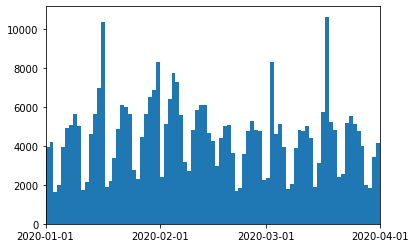

In [7]:
bins = 100
hist = plt.hist(lil_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 3, 15), datetime.date(2020, 4, 1)])
plt.xticks([datetime.date(2020, i, 1) for i in range(1,5)])
plt.show()

In [8]:
"""for j in range(1,4):
    for i in range(1,30):
    #print(len(lil_df[lil_df.values == datetime.date(2020,2,i)]))
        if len(lil_df[lil_df.values == datetime.date(2020,j,i)]) < 3500:
            print('2020-%d-%d' % (j,i))"""
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  after removing the cwd from sys.path.


2020-1-1
2020-1-2
2020-1-4
2020-1-5
2020-1-11
2020-1-12
2020-1-18
2020-1-19
2020-1-20
2020-1-25
2020-1-26
2020-2-1
2020-2-2
2020-2-8
2020-2-9
2020-2-15
2020-2-16
2020-2-17
2020-2-22
2020-2-23
2020-2-29
2020-3-1
2020-3-7
2020-3-8
2020-3-14
2020-3-15
2020-3-21
2020-3-22
2020-3-28
2020-3-29


#### Skewed data of sentence length => most of the quotation have 20 words

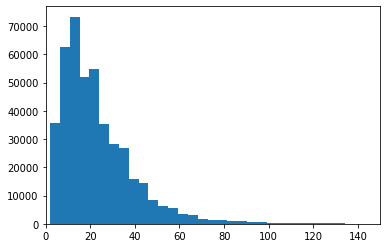

In [9]:
def get_info(x):
    x = x.split(" ")
    return len(x)
lil_df["length_quote"] = lil_df["quotation"].apply(lambda x: get_info(x))
#lil_df = lil_df[lil_df["quotation"].str.len() <=2]
bins = 100
hist = plt.hist(lil_df["length_quote"],bins)
plt.xlim(0,150)
#plt.xticks([datetime.date(2020, i, 1) for i in range(1,4)])
plt.show()

### Analaysis over D vs R

#### Number of Democrats vs number of republicans

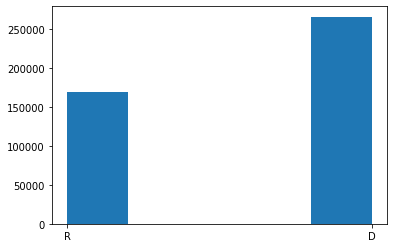

In [10]:
labeled_df
bins = 5
hist = plt.hist(labeled_df["party_label"],bins)
#plt.xticks([datetime.date(2020, i, 1) for i in range(1,4)])
plt.show()

#### Most frequent word used by R and most frequent word used by D

In [11]:
#we want to remove the basic word as conjunction pronouns and so later, so i use this dataset to remove it + WE KEEP ONLY THE NOUNS!(for now)
words_df = pd.read_csv('data.nosync/processed/most-common-words-1k.csv')
#remove the most famous 5 verbs which are like "be,were,do,can"
remove_basic_verbs = words_df[words_df["Main Type"] == "verb"]["Word"].tolist()[:5]
remove_words = words_df[words_df["Main Type"].isin(['preposition', 'conjunction', 'particle', 'pronoun',
       'adverb','verb','determiner','interjection','letter', 'contraction'])]["Word"].tolist()
remove_words = remove_words + remove_basic_verbs

In [12]:
#just to see the most famous used word in general
lil_df["quotation_list"] = lil_df["quotation"].apply(lambda x: x.split(" "))
famous_words_used = lil_df['quotation_list'].explode().value_counts().index[:500].str.lower().tolist()
for word in famous_words_used:
    if word in remove_words:
        famous_words_used.remove(word)

In [13]:
# REPUBLICANS FAMOUS WORDS, DEMOCRATICFAMOUS WORDS
r_famous_words = lil_df[lil_df["party_label"] == "R"]['quotation_list'].explode().value_counts().index[:500].str.lower().tolist()
d_famous_words = lil_df[lil_df["party_label"] == "D"]['quotation_list'].explode().value_counts().index[:500].str.lower().tolist()   
for word in r_famous_words:
    if word in remove_words:
        r_famous_words.remove(word)
        
for word in d_famous_words:
    if word in remove_words:
        d_famous_words.remove(word)

In [14]:
# REPUBLICANS FAMOUS WORDS VS DEMOCRATICS FAMOUS WORDS
#symmetric_difference instead?
words_in_r_and_not_in_d = list(set(r_famous_words) - set(d_famous_words))
words_in_d_and_not_in_r = list(set(d_famous_words) - set(r_famous_words))
print(list(words_in_r_and_not_in_d))
print(list(words_in_d_and_not_in_r))

#Do we see some main words? 

['having', 'someone', 'military', 'financial', 'there,', 'do,', 'set', 'between', 'year,', 'looking', 'reason', 'more', 'significant', 'republican', 'weeks', 'another', 'ready', 'iran', 'free', 'before', 'comes', 'heard', 'response', 'no', 'provide', 'also', 'evidence', 'show', 'human', 'these', 'enough', 'any', 'pretty', 'going', 'situation', 'least', 'take', 'available', 'took', 'efforts', 'chinese', 'how', 'must', 'most', 'really', 'ability', 'well', 'leadership', 'years,', 'can', 'this', 'impeachment', 'level', 'necessary', 'would', 'additional', 'with', 'based', 'which', 'security', 'china', 'possible', 'team', 'me', 'global', 'department', 'up', '&', 'including', "president's", 'problem', 'too']
['if', 'like,', 'you.', 'against', 'campaign', 'it', 'kids', 'never', 'voters', 'everyone', 'single', 'stand', 'after', 'away', 'me.', 'emergency', 'democratic', 'climate', 'joe', 'us,', 'get', 'bernie', 'what', 'war', 'for', 'ensure', 'my', 'few', 'are', 'candidate', 'folks', 'trial', 't

#### Mean lenght of sentence used by the two parties

In [15]:
mean_quote_lenght_D = labeled_df[labeled_df["party_label"] == "D"]["length_quote"].mean()
mean_quote_lenght_R = labeled_df[labeled_df["party_label"] == "R"]["length_quote"].mean()
print(mean_quote_lenght_D)
print(mean_quote_lenght_R)

KeyError: 'length_quote'

## Correlations

#### Most frequent of quotes => correlated to presidential events

In [ ]:
# get top 10 most frequent dates of quotes
n = 10
days_with_most_quotes = lil_df['date'].value_counts()[:n].index.tolist()
days_with_most_quotes

In [ ]:
#As we can see, the first is february 04 and 05. 
#(February 5, 2020). "Trump impeachment vote live updates: Sharply divided Senate acquits Trump on both articles"
#"United States President Donald Trump is acquitted by the United States Senate in his first impeachment trial."

#2020-01-15 -> the Pentagon construction was completed.
#2020-01-30 -> President Trump signed the U.S.-Mexico-Canada (USMCA) trade pact.
#2020-02-07 -> 1A President Trump is acquitted
events = {datetime.date(2020, 2, 5):'T. Imp.',
          datetime.date(2020, 1, 15): 'Pentagon',
          datetime.date(2020, 1, 30):'U-M-C'}

#### Date of senators quotes popular on presidentials month?

In [ ]:
#remove empty values
senators_df = lil_df[lil_df["US_congress_bio_ID"] != None]
senators_df = lil_df[~lil_df["US_congress_bio_ID"].isnull()]
len(senators_df)

In [ ]:
bins = 100
hist = plt.hist(senators_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020,4, 1)])
plt.xticks([list(events)[i] for i in range(0,len(list(events)))],[list(events.values())[i] for i in range(0,len(list(events)))],fontsize=7)
plt.show()

In [ ]:
##non_senators_df_for_comparison
non_senators_df = lil_df[lil_df["US_congress_bio_ID"] == None]
non_senators_df = lil_df[lil_df["US_congress_bio_ID"].isnull()]
len(non_senators_df)

In [ ]:
bins = 100
hist = plt.hist(non_senators_df["date"].dt.date,bins)
plt.xlim([datetime.date(2020, 1, 1), datetime.date(2020,4, 1)])
plt.xticks([list(events)[i] for i in range(0,len(list(events)))],[list(events.values())[i] for i in range(0,len(list(events)))],fontsize=7)
plt.show()

From here we can notice that between senators and non senators there is not so much difference in the amount of quotes